In [11]:
from spreg import OLS, vif, OLS_Regimes
import pysal as ps
import libpysal
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from tobler.area_weighted import area_join, area_interpolate
from pysal.explore import esda
import contextily
import fiona
from sklearn.preprocessing import Normalizer, StandardScaler

In [2]:
env = gpd.read_file('../raw_data/more_maps/environment_2022.shp')


In [3]:
env

,plr,plr_name,kategorie,bioklima,gruenfl,laerm,luft,geometry
0,01100101,Stülerstraße,zweifach,mittel,schlecht,mittel,hoch,"POLYGON ((387952.642 5818274.558, 387924.234 5..."
1,01100102,Großer Tiergarten,keine starke Belastung,mittel,gut,mittel,mittel,"POLYGON ((389869.327 5820074.331, 389869.304 5..."
2,01100103,Lützowstraße,dreifach,hoch,schlecht,gering,hoch,"POLYGON ((387952.642 5818274.558, 387986.686 5..."
3,01100104,Körnerstraße,zweifach,hoch,gut,mittel,hoch,"POLYGON ((389319.585 5817775.805, 389310.128 5..."
4,01100205,Wilhelmstraße,dreifach,hoch,gut,hoch,hoch,"POLYGON ((389835.709 5819672.186, 389851.284 5..."
...,...,...,...,...,...,...,...,...
537,12601032,Rollbergesiedlung,keine starke Belastung,mittel,gut,gering,mittel,"POLYGON ((386416.954 5829708.452, 386392.827 5..."
538,12601133,Treuenbrietzener Straße,keine starke Belastung,mittel,mittel,mittel,mittel,"POLYGON ((389990.688 5829740.615, 389981.590 5..."
539,12601134,Märkisches Zentrum,keine starke Belastung,mittel,mittel,gering,mittel,"POLYGON ((387367.428 5828619.763, 387315.862 5..."
540,12601235,Dannenwalder Weg,einfach,mittel,schlecht,mittel,mittel,"POLYGON ((389475.323 5828740.790, 389470.683 5..."


In [192]:
oeffi = gpd.read_file('../raw_data/maps/stations.shp')


In [193]:
oeffi

,Bahn_Typ_k,Bahn_Typ,geometry
0,S_R,"S-, Regionalbahn",POINT (405681.637 5818896.470)
1,S,S-Bahn,POINT (403304.504 5819005.608)
2,S,S-Bahn,POINT (408219.291 5819249.663)
3,S,S-Bahn,POINT (410018.541 5819495.176)
4,S,S-Bahn,POINT (411833.945 5819740.138)
...,...,...,...
1039,R,Regionalbahn,POINT (393302.162 5788522.695)
1040,R,Regionalbahn,POINT (393335.208 5786602.202)
1041,R,Regionalbahn,POINT (395187.861 5780652.251)
1042,R,Regionalbahn,POINT (395952.129 5777589.272)


<AxesSubplot:>

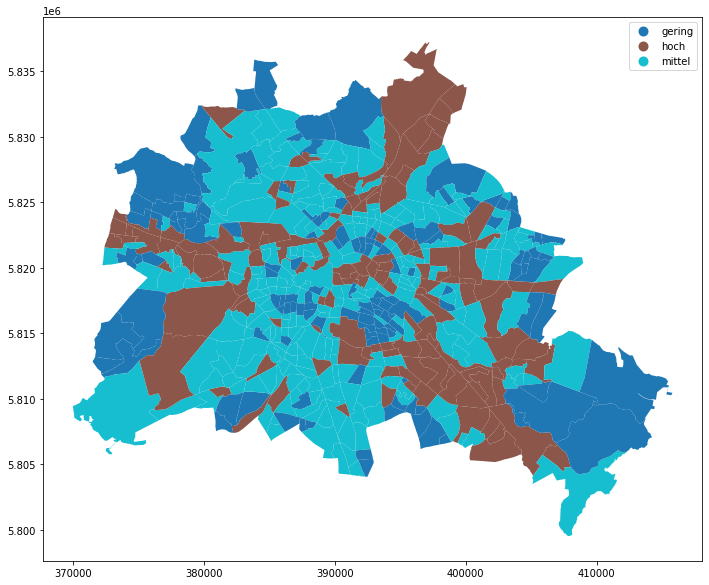

In [4]:
env.plot('laerm', figsize=(15,10),legend=True) 

In [7]:
# Load regression gds 
selected = gpd.read_file('../YouthInTheCity/data/regression_gdf.shp')


# Select features manually
selected.drop(columns=['HK_EU15', 'HK_EU28', 'HK_Polen', 'HK_EheJug', 'HK_EheSU', 'HK_Turk',
              'schools', 'universiti','kindergart','HK_Arab', 'HK_Sonst', 'HK_NZOrd', 'BZR_NAME', 
              'noise',  'health_car', 'vegpm10', 'change','ch_rate',
            'public_tra', 'green' ,'other_sch', 'secon_sch','vocat_sch',
                'sp_nee_sch','eating', 'community','night_life', 'water',  
              'public_ser','dyn_ew', 'dyn_unempl', 'priv_schoo', 'primary_sc',
                       'education', 'five_y_pls', 'dyn_sales','air', 'bio'], inplace=True)

# Export it as shapefile
selected.to_file('../raw_data/basic_model_gdf.shp', mode="w")

# Load it again
selected = gpd.read_file('../raw_data/basic_model_gdf.shp')

In [8]:
# loading dbf
db = libpysal.io.open('../raw_data/basic_model_gdf.dbf','r')

# computing spatial weights
queen = libpysal.weights.Queen.from_dataframe(selected)
inv_dist = libpysal.weights.DistanceBand.from_dataframe(selected, 5000, geom_col='geometry', binary=False)
rook = libpysal.weights.Rook.from_dataframe(selected)

In [16]:
corr = selected.corr()
corr_df = corr.unstack().reset_index() #Unstack correlation matrix
corr_df.columns = ["feature_1", "feature_2", "correlation"] #Rename the columns
corr_df.sort_values(by="correlation", ascending=False, inplace=True)
corr_df = corr_df[corr_df["feature_1"] != corr_df["feature_2"]] #remove the self-corr
corr_df.head(20)

,feature_1,feature_2,correlation
60,mig_rate,child_pov,0.648544
108,child_pov,mig_rate,0.648544
144,kita,culture,0.631574
24,culture,kita,0.631574
18,culture,ave_rent,0.568511
66,ave_rent,culture,0.568511
17,culture,mig_rate,0.470438
53,mig_rate,culture,0.470438
148,kita,ave_rent,0.461691
76,ave_rent,kita,0.461691


In [ ]:
y = Normalizer().fit_transform(selected['child_pov'].reshape(-1, 1))
X = selected.drop(columns=[
    'PLR_ID','child_pov', 'geometry']).to_numpy()

In [15]:
y = StandardScaler().fit_transform(np.array(selected['child_pov']).reshape(-1, 1))
X = selected.drop(columns=[
    'PLR_ID','child_pov', 'geometry']).to_numpy()

In [18]:
selected.columns

Index(['PLR_ID', 'culture', 'outdoor_fa', 'outdoor_le', 'mig_rate', 'ave_rent',
       'social_hou', 'public_hou', 'child_pov', 'vegpm20', 'Gymnasium', 'kita',
       'stations', 'geometry'],
      dtype='object')

In [18]:
columns = [
'culture', 'outdoor_fa', 'outdoor_le', 'mig_rate', 'ave_rent',
       'social_hou', 'public_hou', 'vegpm20', 'Gymnasium', 'kita',
       'stations'
]

In [19]:
m1 = OLS(y,
        X,
        w=inv_dist,
        name_y='child_pov',
        name_x=columns,
        name_w='dist',
        name_ds='basic_model',
        white_test=True,
        gwk=inv_dist,
        spat_diag=True,
        moran=True)

(array([ 18.,  38.,  86., 102.,  98.,  90.,  41.,  32.,  24.,   7.]),
 array([-4.53833424,  2.08280928,  8.7039528 , 15.32509632, 21.94623984,
        28.56738336, 35.18852688, 41.8096704 , 48.43081392, 55.05195744,
        61.67310096]),
 <BarContainer object of 10 artists>)

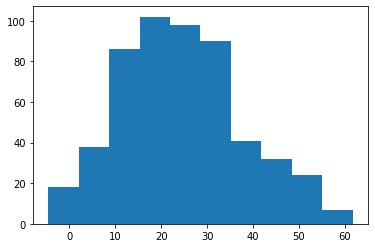

In [21]:
plt.hist(m1.predy.flatten())

<AxesSubplot:>

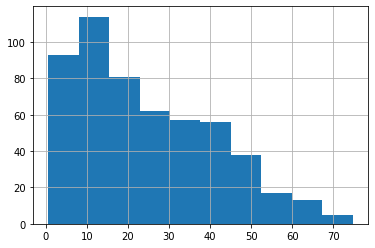

In [22]:
selected['child_pov'].hist()

In [29]:
m2.predy.flatten()

array([-0.8031057 , -0.43153063,  0.81066686, -0.34794438,  1.60412397,
       -0.60651   ,  1.84815527, -0.02090844, -0.42486181, -0.88961078,
       -0.06364212,  0.85275827, -0.41598448,  0.65422481, -1.09791317,
        0.53200042, -0.69886143,  0.34947055, -0.18266786, -0.67733739,
       -0.48353549, -0.29934644,  1.91703087, -0.60981862, -0.89914473,
       -0.03746991,  0.27448299,  0.46635589,  0.43050638, -0.16139891,
       -1.58372909,  0.57493112,  0.68239494, -0.55100928,  0.5709344 ,
        0.43276529,  0.99743447,  1.0282465 , -0.2066888 , -0.1406528 ,
       -0.99576258, -0.79612552, -1.04469877, -0.16865851,  0.19760185,
        0.15787183,  2.40165626, -0.76264279, -0.66896858, -0.16135252,
        0.05884814, -0.71799205, -0.84735522, -0.27994798, -0.58154088,
       -0.32096935,  0.78294638, -0.32801556,  0.59475778, -0.7182299 ,
       -0.77160952, -0.23183665,  1.1713204 ,  0.98502707,  1.5617851 ,
        1.91786356, -0.0762227 ,  0.79210192,  0.44344696, -0.06

In [28]:
mae(y, m2.predy.flatten())

0.426340381970649

In [30]:
np.sqrt(mse(y, m1.predy.flatten()))

0.5937538674641627

In [20]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            : basic_model
Weights matrix      :        dist
Dependent Variable  :   child_pov                Number of Observations:         536
Mean dependent var  :      0.0000                Number of Variables   :          12
S.D. dependent var  :      1.0009                Degrees of Freedom    :         524
R-squared           :      0.6475
Adjusted R-squared  :      0.6401
Sum squared residual:     188.963                F-statistic           :     87.4855
Sigma-square        :       0.361                Prob(F-statistic)     :  5.107e-111
S.E. of regression  :       0.601                Log likelihood        :    -481.139
Sigma-square ML     :       0.353                Akaike info criterion :     986.279
S.E of regression ML:      0.5938                Schwarz criterion     :    1037.688

-----------------------------------------------------------------------------

In [91]:
mae(clusters.child_pov, m1.predy)

7.774393615939689

In [29]:
# creating vif dataframe

v = vif(m1)
del(v[0])
vif_array = np.array(v, dtype=float)

v_d = pd.DataFrame({'feature': columns, 
                   'vif': vif_array[:,0], 
                   'tolerance':  vif_array[:,1]})

v_d

,feature,vif,tolerance
0,culture,2.397991,0.417016
1,outdoor_fa,1.647425,0.607008
2,outdoor_le,1.216286,0.822175
3,mig_rate,1.889575,0.529220
4,ave_rent,1.975711,0.506147
5,social_hou,1.426457,0.701038
6,public_hou,1.601367,0.624467
7,vegpm20,1.144803,0.873513
8,Gymnasium,1.221575,0.818615
9,kita,2.101626,0.475822


<AxesSubplot:>

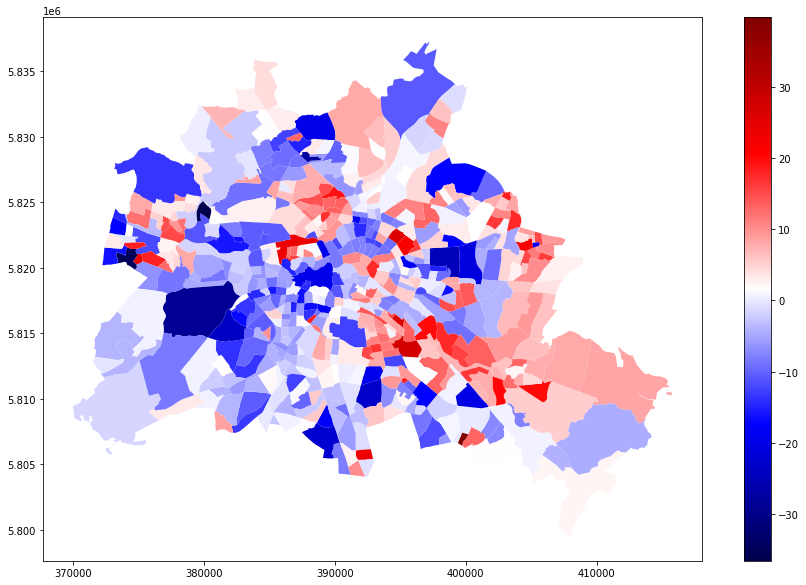

In [31]:
# Adding a resituals column to sample dataframe
selected['residuals'] = m1.u

# plotting residuals - red = underestimation, blue = overestimation
selected.plot('residuals', figsize=(15,10), cmap= 'seismic', legend=True)

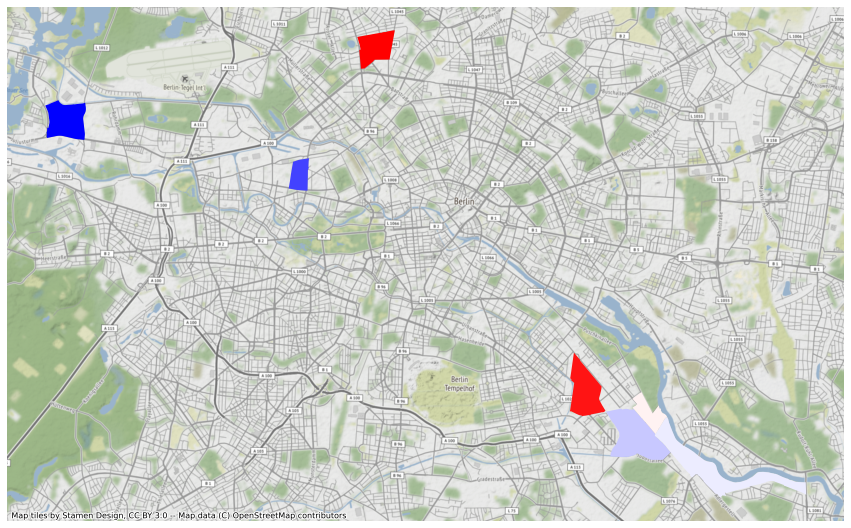

In [36]:
# instantiating knn
knn = libpysal.weights.KNN.from_dataframe(selected, k=5)
# Row standardise weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001
# Add `error_clusters` and `local_I` columns
ax = (
    selected.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".", figsize=(15,10))
)
# Add basemap
contextily.add_basemap(ax, crs=selected.crs)
# Remove axes
ax.set_axis_off();

In [29]:
pr2021 = gpd.read_file('../raw_data/maps/pr_2021.shp')

pr2020 = gpd.read_file('../raw_data/maps/pr_2020.shp')

In [21]:
# loading east/west maps
west = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_West_EPSG54030.shp')
east = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_Ost_EPSG54030.shp')

# adapting projections
east.to_crs(crs='EPSG:25833', inplace=True)
west.to_crs(crs='EPSG:25833', inplace=True)

# dissolving
west = west.dissolve()
east = east.dissolve()

# merging both maps into an eastwest geodataframe
eastwest = east.append(west)

# adding an east column to eastwest geodataframe
eastwest['east'] = eastwest.OBJECTID.map({1:1,
                                             2:0})

eastwest = eastwest[['east','geometry']]

# merging eastwest geodataframe with sample df

selected_east = selected.sjoin_nearest(
    eastwest, how='left').dissolve(
    by='PLR_ID')

selected = selected.merge(selected_east.reset_index()[['PLR_ID','east']], on='PLR_ID')

In [22]:
X.shape

(536, 11)

In [24]:
# Running an OLS Regimes model

m2 = OLS_Regimes(y,
                X,
                w=inv_dist,
                regimes=selected['east'],
                name_y='child_pov',
                name_x=columns,
                name_w='dist',
                name_ds='basic_model',
                white_test=True,
                spat_diag=True,
                moran=True)

In [25]:
print(m2.summary)

REGRESSION
----------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME 0
---------------------------------------------------------------
Data set            : basic_model
Weights matrix      :        dist
Dependent Variable  : 0_child_pov                Number of Observations:         195
Mean dependent var  :     -0.1990                Number of Variables   :          12
S.D. dependent var  :      0.9175                Degrees of Freedom    :         183
R-squared           :      0.6741
Adjusted R-squared  :      0.6545
Sum squared residual:      53.215                F-statistic           :     34.4146
Sigma-square        :       0.291                Prob(F-statistic)     :   7.068e-39
S.E. of regression  :       0.539                Log likelihood        :    -150.074
Sigma-square ML     :       0.273                Akaike info criterion :     324.147
S.E of regression ML:      0.5224                Schwarz criterion     :     363.423

--------------------------------

In [26]:
mae(clusters.child_pov, m2.predy)

NameError: name 'clusters' is not defined

<AxesSubplot:>

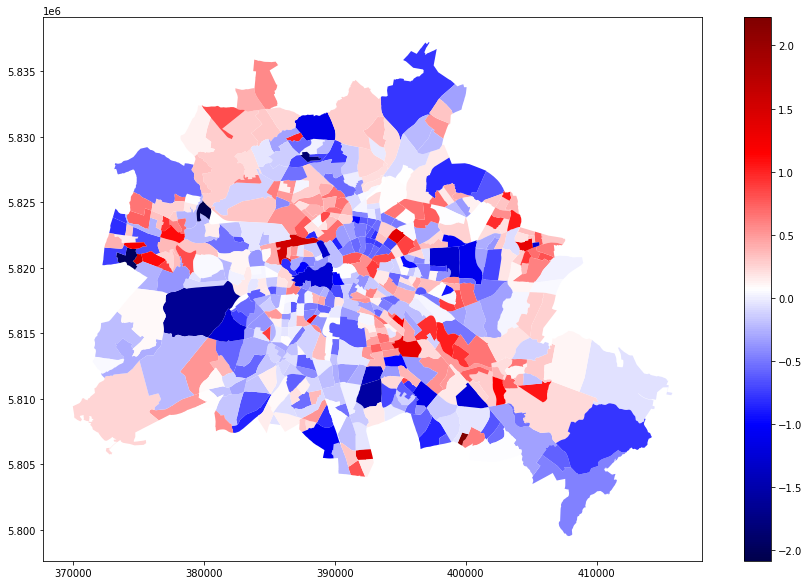

In [27]:
# Adding a resituals column to sample dataframe
selected['residuals_m2'] = m2.u

# plotting residuals - red = underestimation, blue = overestimation
selected.plot('residuals_m2', figsize=(15,10), cmap= 'seismic', legend=True)

In [53]:
clusters = gpd.read_file('../raw_data/output_maps/2kgdf.shp')

In [62]:
clusters.columns

Index(['PLR_ID', 'public_tra', 'eating', 'community', 'health_car',
       'public_ser', 'education', 'universiti', 'outdoor_fa', 'outdoor_le',
       'water', 'ave_rent', 'social_hou', 'public_hou', 'rent_to_pr',
       'dyn_r_to_p', 'sales', 'dyn_sales', 'child_pov', 'air', 'bio', 'B_1940',
       'B_1941_199', 'B_1991_201', 'vegpm20', 'other_sch', 'vocat_sch',
       'primary_sc', 'Gymnasium', 'secon_sch', 'priv_schoo', 'kita',
       'stations', 'k5cls', 'geometry'],
      dtype='object')

In [ ]:
cluste

In [79]:
columns =['eating', 'public_ser', 'education', 'outdoor_fa', 'outdoor_le', 'ave_rent', 
          'social_hou', 'public_hou', 'rent_to_pr', 'vegpm20','Gymnasium','kita'
         ]

In [81]:
y_c = np.array(clusters['child_pov'])
X_c = clusters.drop(columns=[
    'PLR_ID','child_pov', 'k5cls','public_tra','geometry','dyn_r_to_p','secon_sch', 
    'dyn_sales', 'priv_schoo','other_sch', 'vocat_sch','B_1940','universiti',  'water', 
       'B_1941_199', 'B_1991_201','air', 'community','bio', 'sales',
       'primary_sc']).to_numpy()

In [84]:
# Running an OLS Regimes model

m3 = OLS_Regimes(y_c,
                X_c,
                w=inv_dist,
                regimes=clusters['k5cls'],
                name_y='child_pov',
                name_x=columns,
                name_w='dist',
                name_ds='basic_model',
                white_test=True,
                spat_diag=True,
                moran=True)

In [85]:
print(m3.summary)

REGRESSION
----------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME 0
---------------------------------------------------------------
Data set            : basic_model
Weights matrix      :        dist
Dependent Variable  : 0_child_pov                Number of Observations:         350
Mean dependent var  :     23.9585                Number of Variables   :          15
S.D. dependent var  :     16.2402                Degrees of Freedom    :         335
R-squared           :      0.3603
Adjusted R-squared  :      0.3336
Sum squared residual:   58881.804                F-statistic           :     13.4776
Sigma-square        :     175.767                Prob(F-statistic)     :   2.565e-25
S.E. of regression  :      13.258                Log likelihood        :   -1393.565
Sigma-square ML     :     168.234                Akaike info criterion :    2817.131
S.E of regression ML:     12.9705                Schwarz criterion     :    2875.000

--------------------------------

In [89]:
mae(clusters.child_pov, m3.predy)

9.771951176085265

<AxesSubplot:>

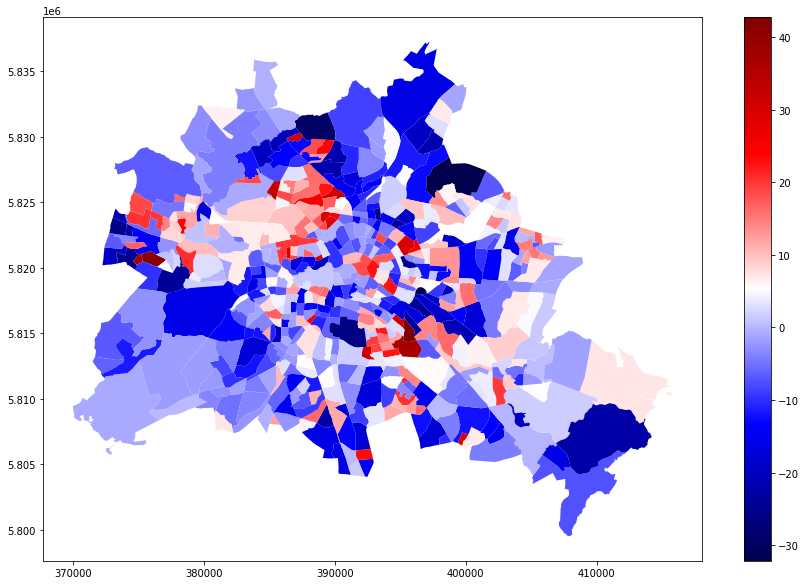

In [88]:
# Adding a resituals column to sample dataframe
clusters['residuals_m3'] = m3.u

# plotting residuals - red = underestimation, blue = overestimation
clusters.plot('residuals_m3', figsize=(15,10), cmap= 'seismic', legend=True)